In [325]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms as T
from torchsummary import summary

import os
import glob
import cv2
from pathlib import Path
import copy

%matplotlib inline
torch.manual_seed(1221)

In [326]:
# Defining the paths
data_dir = './data/emergency_vs_non-emergency_dataset/'

In [327]:
# Dataset Class
class DataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        super(DataSet, self).__init__()
        self.data_dir = data_dir
        self.csv_file = Path(self.data_dir).joinpath('emergency_train.csv')
        self.label_df = pd.read_csv(self.csv_file)
        self.img_dim = (224, 224)
        self.transform = transform
       
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, index):
        img_path, label = (str(Path(self.data_dir).joinpath('images', 
                                                           f"{self.label_df['image_names'][index]}")), 
                           int(self.label_df['emergency_or_not'][index]))
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = img / 255  
        
        img_tensor = torch.from_numpy(img).float()
        img_tensor = img_tensor.permute(2, 0, 1)
        if self.transform:
            img_tensor = self.transform(img_tensor)
    
        class_id = torch.tensor(label)
        
        return img_tensor, class_id

In [328]:
# dataset hyperparameters
val_split = 0.1

# dataset transforms
data_transform = T.Compose([T.RandomHorizontalFlip()])
data_set = DataSet(data_dir, data_transform)

# Spliliting train and validation
dataset_size = len(data_set)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
train_dataset, val_dataset = random_split(data_set, (dataset_size-split, split))
print(f' train dataset size: {train_dataset.__len__()}\n validation dataset size: {val_dataset.__len__()}')
print(f' train image shape {train_dataset[0][0].shape}\n train label shape: {train_dataset[0][1].shape}')
print(f' validation image shape {val_dataset[0][0].shape}\n valodation label shape: {val_dataset[0][1].shape}')

 train dataset size: 1482
 validation dataset size: 164
 train image shape torch.Size([3, 224, 224])
 train label shape: torch.Size([])
 validation image shape torch.Size([3, 224, 224])
 valodation label shape: torch.Size([])


In [336]:
# data loader
batch_size= 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
print(f' N. train batches: {len(train_loader)}\n N. validation batches: {len(val_loader)}')

for imgs, labels in train_loader:
    print(" Batch of train images has shape: ",imgs.shape)
    print(" Batch of train labels has shape: ", labels.shape)
    break
for imgs, labels in val_loader:
    print(" Batch of validation images has shape: ",imgs.shape)
    print(" Batch of validation labels has shape: ", labels.shape)
    break


 N. train batches: 47
 N. validation batches: 6
 Batch of train images has shape:  torch.Size([32, 3, 224, 224])
 Batch of train labels has shape:  torch.Size([32])
 Batch of validation images has shape:  torch.Size([32, 3, 224, 224])
 Batch of validation labels has shape:  torch.Size([32])


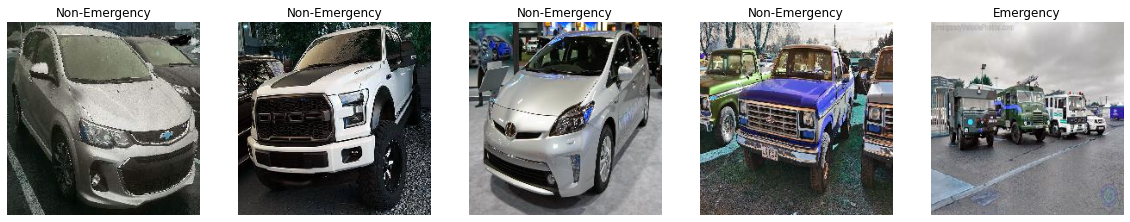

In [337]:
# Display some training image
qty = 5
idx = np.random.randint(int(train_dataset.__len__()), size=qty)
fig , axs = plt.subplots(1, qty, figsize=(20, 20))

for i in range(qty): 
    axs[i].imshow(train_loader.dataset[idx[i]][0].permute(1, 2, 0))
    axs[i].axis('off')
    if (train_loader.dataset[idx[i]][1] == 1):
        axs[i].set_title('Emergency')
    else:
        axs[i].set_title('Non-Emergency')

In [338]:
model = models.vgg16_bn(pretrained=True)

In [339]:
for param in model.parameters():
    param.requires_grad = False
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features=in_features, out_features=2)
summary(model, input_size=(3, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
       BatchNorm2d-2         [32, 64, 224, 224]             128
              ReLU-3         [32, 64, 224, 224]               0
            Conv2d-4         [32, 64, 224, 224]          36,928
       BatchNorm2d-5         [32, 64, 224, 224]             128
              ReLU-6         [32, 64, 224, 224]               0
         MaxPool2d-7         [32, 64, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]          73,856
       BatchNorm2d-9        [32, 128, 112, 112]             256
             ReLU-10        [32, 128, 112, 112]               0
           Conv2d-11        [32, 128, 112, 112]         147,584
      BatchNorm2d-12        [32, 128, 112, 112]             256
             ReLU-13        [32, 128, 112, 112]               0
        MaxPool2d-14          [32, 128,

In [340]:
learning_rate=.0005
n_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=learning_rate)

In [341]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_cost=[]
val_cost = []

for epoch in tqdm(range(n_epochs)):
    print(f'Epoch {epoch}/{n_epochs-1}')
    print('-'*10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader
        
        running_loss = 0.
        running_corrects = 0
        
        for inputs , labels in dataloader:
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds==labels.data)
    
        if phase == 'train':
            epoch_loss = running_loss / train_dataset.__len__()
            epoch_acc = running_corrects / train_dataset.__len__()
            train_cost.append(epoch_loss)
        else:
            epoch_loss = running_loss / val_dataset.__len__()
            epoch_acc = running_corrects / val_dataset.__len__()
            val_cost.append(epoch_loss)
            
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if phase == 'val' and epoch_acc > best_acc:
            print('Acuuracy improved. Saving the best model...')
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

print(f'Best val Acc: {best_acc:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
train Loss: 0.3454 Acc: 0.8462
val Loss: 0.2380 Acc: 0.9146
Acuuracy improved. Saving the best model...


 10%|█         | 1/10 [13:21<2:00:10, 801.21s/it]

Epoch 1/9
----------
train Loss: 0.2322 Acc: 0.9001


 20%|██        | 2/10 [26:34<1:46:30, 798.81s/it]

val Loss: 0.2288 Acc: 0.9085
Epoch 2/9
----------
train Loss: 0.2237 Acc: 0.9062


 30%|███       | 3/10 [39:49<1:33:04, 797.79s/it]

val Loss: 0.2280 Acc: 0.8902
Epoch 3/9
----------
train Loss: 0.2115 Acc: 0.9150
val Loss: 0.2053 Acc: 0.9268
Acuuracy improved. Saving the best model...


 40%|████      | 4/10 [53:40<1:20:46, 807.80s/it]

Epoch 4/9
----------


 40%|████      | 4/10 [54:35<1:21:53, 818.85s/it]


KeyboardInterrupt: 

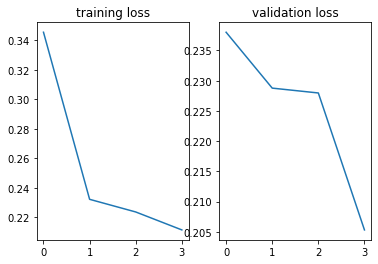

In [343]:
# Cost curves
fig , axs = plt.subplots(1, 2)

axs[0].plot(train_cost)
axs[0].set_title('training loss')
axs[1].plot(val_cost)
axs[1].set_title('validation loss')
plt.show()